# Contrôle synthétique
# 15 juillet 2021
# @author : jeremylhour

NB : avant de lancer ce code, lancer le script "synth_setup.sh" qui permet de télécharger les données de consommation de tabac aux US, et les placer à la racine dans data/MLAB_data.txt

In [ ]:
! source synth_setup.sh

In [ ]:
rm(list=ls())

packageList = c('Synth')
#for(pack in packageList) install.packages(pack)
lapply(packageList, require, character.only = TRUE)

Loading required package: Synth

##
## Synth Package: Implements Synthetic Control Methods.


## See http://www.mit.edu/~jhainm/software.htm for additional information.





[[1]]
[1] TRUE

# 1. MISE EN FORME DES DONNEES

In [ ]:
DATA_PATH = '../data/MLAB_data.txt'

data = data.frame(t(read.table(DATA_PATH)))

smokeNames = mapply(function(x) paste("SmokingCons", x, sep=""), 1970:2000) # noms de variables pour la conso de tabac
                    
names = c("State_ID",
          "Income",
          "RetailPrice",
          "Young",
          "BeerCons",
          "Smoking1988",
          "Smoking1980",
          "Smoking1975",
           smokeNames)
colnames(data) = names

stateNames = c('Alabama', 'Arkansas','Colorado','Connecticut','Delaware',
               'Georgia',  'Idaho',  'Illinois',  'Indiana', 'Iowa', 'Kansas',
               'Kentucky', 'Louisiana', 'Maine', 'Minnesota', 'Mississippi',
               'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
               'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
               'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
               'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia' , 'West Virginia',
               'Wisconsin', 'Wyoming', 'California')
rownames(data) = stateNames
data[, "Treated"] = as.numeric(data[,"State_ID"]==3) # la Californie est l'Etat avec ID=3
                  
head(data)

[1] "================================================================================"
[1] "MISE EN FORME DES DONNEES"
[1] "================================================================================"


,State_ID,Income,RetailPrice,Young,BeerCons,Smoking1988,Smoking1980,Smoking1975,SmokingCons1970,SmokingCons1971,⋯,SmokingCons1992,SmokingCons1993,SmokingCons1994,SmokingCons1995,SmokingCons1996,SmokingCons1997,SmokingCons1998,SmokingCons1999,SmokingCons2000,Treated
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,1,9.678974,89.34445,0.1748019,18.96,112.1,123.2,111.7,89.8,95.4,⋯,109.1,108.5,107.1,102.6,101.4,104.9,106.2,100.7,96.2,0
Arkansas,2,9.643623,89.87778,0.1646114,18.52,121.5,131.8,114.8,100.3,104.1,⋯,126.0,113.8,108.8,113.0,110.7,108.7,109.5,104.8,99.4,0
Colorado,4,9.984357,82.62222,0.1737032,25.08,94.6,131.0,131.0,124.8,125.5,⋯,88.3,88.6,89.1,85.4,83.1,81.3,81.2,79.6,73.0,0
Connecticut,5,10.188035,103.47778,0.1636597,20.70,104.8,118.0,110.2,120.0,117.6,⋯,83.5,79.1,76.6,79.3,76.0,75.9,75.5,73.4,71.4,0
Delaware,6,9.974561,90.05556,0.1782245,26.08,137.1,150.5,147.6,155.0,161.1,⋯,120.0,123.8,126.1,127.2,128.3,124.1,132.8,139.5,140.7,0
Georgia,7,9.817172,84.36667,0.1769441,21.76,124.1,134.0,122.9,109.9,115.7,⋯,109.2,109.2,107.8,100.3,102.7,100.6,100.5,97.1,88.4,0


# 1. FIGURE 10.3

[1] "================================================================================"
[1] "REPRODUCTION DE LA FIGURE 1"
[1] "================================================================================"


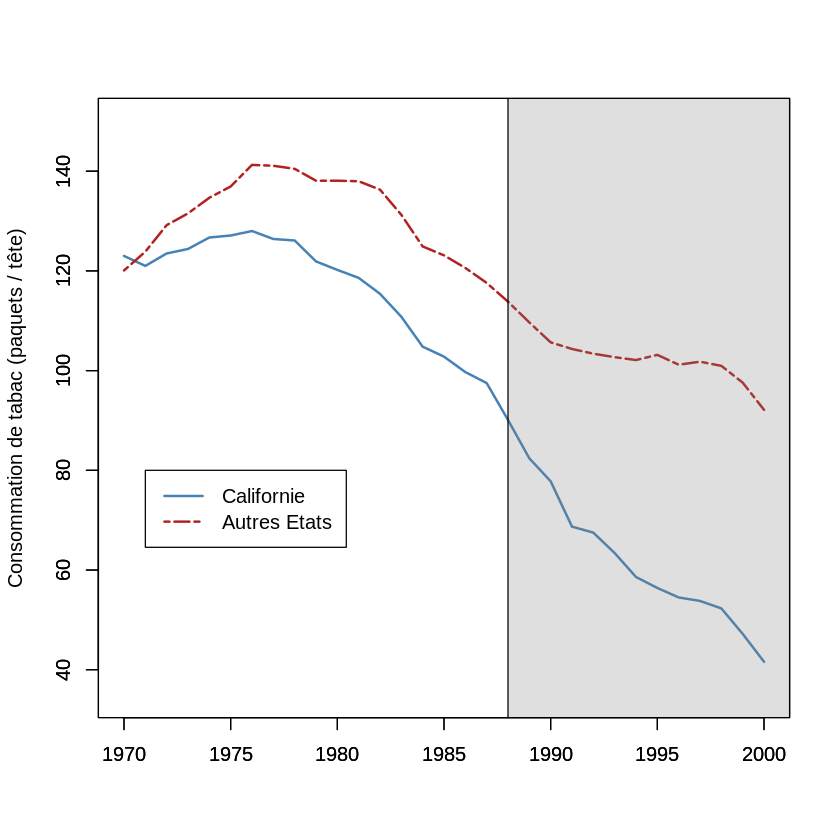

In [ ]:
plotdata = ts(cbind(unlist(data[data[,"Treated"]==1, smokeNames]),
                    unlist(apply(data[data[,"Treated"]==0, smokeNames], 2, mean))),start=c(1970), freq=1)

plot(plotdata, plot.type="single",
     col=c("steelblue","firebrick"), lwd=2,
     lty=c(1, 6),xlab="", ylab="Consommation de tabac (paquets / tête)",
     ylim=c(35,150))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,80,
       legend=c("Californie", "Autres Etats"),
       col=c("steelblue","firebrick"), lwd=2,
       lty=c(1,6))

On peut constater que la consommation de tabac par tête en Californie est bien inférieure à la moyenne des autres Etats, et tend à diminue plus rapidement. Il n'y a clairement pas de tendance commune.

In [ ]:
# SAUVEGARDE
jpeg("Tobacco_Fig_1.jpg",res=150, width = 1000, height = 1000)
plot(plotdata, plot.type="single",
     col=c("steelblue","firebrick"), lwd=2,
     lty=c(1, 6),xlab="", ylab="Consommation de tabac (paquets / tête)",
     ylim=c(35,150))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,80,
       legend=c("Californie", "Autres Etats"),
       col=c("steelblue","firebrick"), lwd=2,
       lty=c(1,6))
dev.off()

png 
  2

# 2. ESTIMATION -- CALCUL DU CONTROLE SYNTHETIQUE

In [ ]:
X1 = t(data[data[,"Treated"]==1, c("Income", "RetailPrice", "Young", "BeerCons", "Smoking1988","Smoking1980","Smoking1975")])
X0 = t(data[data[,"Treated"]==0, c("Income", "RetailPrice", "Young", "BeerCons", "Smoking1988","Smoking1980","Smoking1975")])

Z1 = t(data[data[,"Treated"]==1, mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)])
Z0 = t(data[data[,"Treated"]==0, mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)])

solution = synth(X1=X1,
                 X0=X0,
                 Z0=Z0,
                 Z1=Z1,
                 custom.v = NULL,
                 optimxmethod = "Nelder-Mead",
                 verbose=TRUE)       
                                 
W = solution$solution.w
print(round(W, 3))
                                        
V_sol = solution$solution.v

[1] "================================================================================"
[1] "CALCUL DES POIDS"
[1] "================================================================================"
X1,X0,Z1,Z0 were individually input (not dataprep object.)


**************** 
 searching for synthetic control unit  
 
                      p1        p2        p3          p4        p5          p6
Nelder-Mead -0.002084832 0.1394833 0.3560638 -0.01424623 0.2791152 -0.02033223
                   p7    value fevals gevals niter convcode kkt1 kkt2  xtime
Nelder-Mead 0.1714994 4.412518    502     NA    NA        1   NA   NA 26.723
                      p1         p2           p3          p4         p5
Nelder-Mead 0.0006542238 0.03495713 -0.003775559 -0.01394098 0.07644841
                   p6       p7    value fevals gevals niter convcode kkt1 kkt2
Nelder-Mead 0.4392839 0.552291 3.209078    502     NA    NA        1   NA   NA
             xtime
Nelder-Mead 32.348

 Equal weight loss is: 4.4125

On peut constater qu'aux erreurs numériques près, on reproduit bien les résultats d'Abadie et al. (2010).

# 3. ESTIMATION -- ANALYSE DES RESULTATS -- Tableau 10.2 et figure 10.4

In [ ]:
tableau1 = round(cbind(X1, X0%*%W ,apply(X0, 1, mean)), 1)
colnames(tableau1) = c("Californie observée", "Californie synthétique", "Moyenne des 38 autres Etats")
print(tableau1)

write.table(tableau1, "tableau1.txt", append = FALSE, quote = FALSE, sep = " & ",
            eol = paste(" \\\\ \n"), na = "--", dec = ".", row.names = T,
            col.names = T)

[1] "================================================================================"
[1] "TABLEAU DE DISTANCE D'APPARIEMMENT"
[1] "================================================================================"
            Californie observée Californie synthétique
Income                     10.1                    9.9
RetailPrice                89.4                   89.3
Young                       0.2                    0.2
BeerCons                   24.3                   24.1
Smoking1988                90.1                   91.4
Smoking1980               120.2                  120.2
Smoking1975               127.1                  126.9
            Moyenne des 38 autres Etats
Income                              9.8
RetailPrice                        87.3
Young                               0.2
BeerCons                           23.7
Smoking1988                       113.8
Smoking1980                       138.1
Smoking1975                       136.9


On reproduit également les résultats de la Table 1. On constate que la Californie synthétique offre un bien meilleur contrefactuel que la moyenne simple des autres Etats.

[1] "================================================================================"
[1] "REPRODUCTION DES FIGURES 2 ET 3"
[1] "================================================================================"


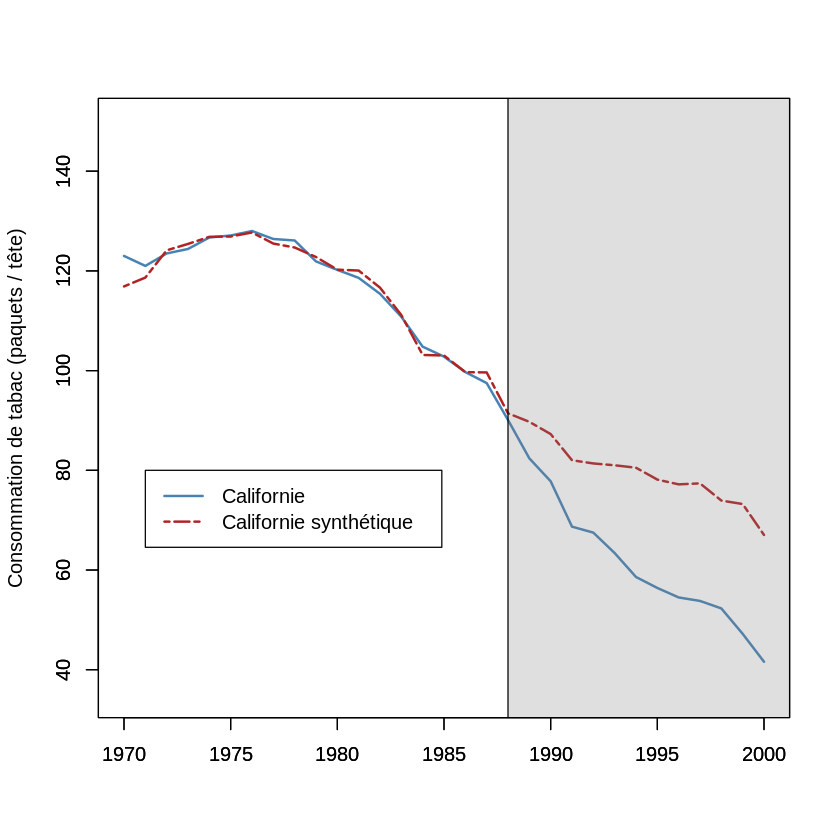

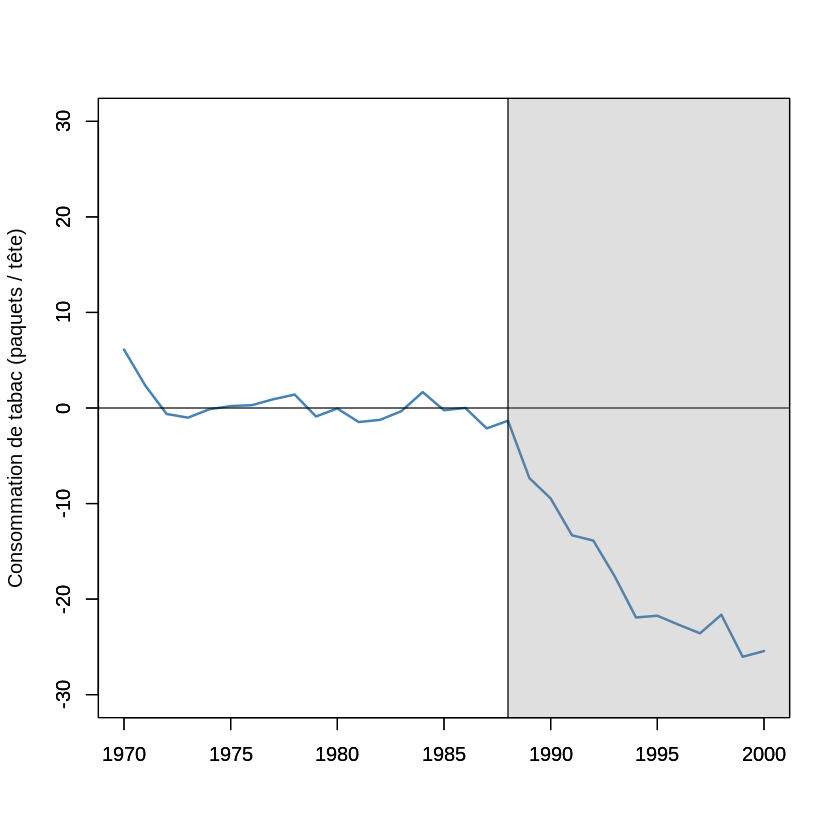

In [ ]:
print(paste(rep("=", 80), collapse=""))
print("REPRODUCTION DES FIGURES 2 ET 3")
print(paste(rep("=", 80), collapse=""))

# FIG 2
plotdata = ts(cbind(unlist(data[data[,"Treated"]==1, smokeNames]),
                    unlist(t(as.matrix(data[data[,"Treated"]==0, smokeNames]))%*%W)),start=c(1970), freq=1)


plot(plotdata, plot.type="single",
     col=c("steelblue","firebrick"), lwd=2,
     lty=c(1, 6),xlab="", ylab="Consommation de tabac (paquets / tête)",
     ylim=c(35,150))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,80,
       legend=c("Californie", "Californie synthétique"),
       col=c("steelblue","firebrick"), lwd=2,
       lty=c(1,6))

# FIG 3
treatmentEffect_hat = data[data[,"Treated"]==1, smokeNames] - t(as.matrix(data[data[,"Treated"]==0, smokeNames]))%*%W
treatmentPlot = ts(unlist(treatmentEffect_hat),start=c(1970), freq=1)

plot(treatmentPlot, plot.type="single",
     col=c("steelblue"), lwd=2,
     lty=c(1),xlab="", ylab="Consommation de tabac (paquets / tête)",
     ylim=c(-30,30))
abline(h=0, lty=c(1))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,80,
       legend=c("Effet du traitement"),
       col=c("steelblue"), lwd=2,
       lty=c(1,6))

In [ ]:
# SAUVEGARDE

jpeg("Tobacco_Fig_2_3.jpg", res=150, width = 1500, height = 750)
par(mfrow=c(1,2))
plot(plotdata, plot.type="single",
     col=c("steelblue","firebrick"), lwd=2,
     lty=c(1, 6),xlab="", ylab="Consommation de tabac (paquets / tête)",
     ylim=c(35,150))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971, 60,
       legend=c("Californie", "Californie synthétique"),
       col=c("steelblue","firebrick"), lwd=2,
       lty=c(1,6))

plot(treatmentPlot, plot.type="single",
     col=c("steelblue"), lwd=2,
     lty=c(1),xlab="", ylab="Consommation de tabac (paquets / tête)",
     ylim=c(-30,30))
abline(h=0, lty=c(1))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,80,
       legend=c("Effet du traitement"),
       col=c("steelblue"), lwd=2,
       lty=c(1,6))
dev.off()

png 
  2

# 4. INFERENCE -- Figure 10.5

In [ ]:
# On fait comme si chaque Etat était traité
contrefactuels = matrix(nrow=nrow(data), ncol=length(smokeNames))
weights = matrix(nrow=nrow(data), ncol=nrow(data)-1)

for(i in data[, "State_ID"]){
    print(paste('Calcul du contrefactuel pour Etat', i))
    
    # Mise en place des bonnes matrices
    X1 = t(data[data[, "State_ID"]==i, c("Income", "RetailPrice", "Young", "BeerCons", "Smoking1988", "Smoking1980", "Smoking1975")])
    X0 = t(data[data[, "State_ID"]!=i, c("Income", "RetailPrice", "Young", "BeerCons", "Smoking1988", "Smoking1980", "Smoking1975")])

    Z1 = t(data[data[, "State_ID"]==i, mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)])
    Z0 = t(data[data[, "State_ID"]!=i, mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)])
    
    # Calcul des poids
    error = FALSE
    tryCatch({
        sol = synth(X1=X1, X0=X0, Z0=Z0, Z1=Z1, V=V_sol, optimxmethod = "Nelder-Mead", verbose=FALSE)
    }, error = function(e){
        error = TRUE
    })
                                              
    if(error){
        print('Error for this state')
    } else {
    W = sol$solution.w
    weights[i,] = W
    # Calcul du contrefactuel
    contrefactuels[i,] = t(as.matrix(data[data[, "State_ID"]!=i, smokeNames]))%*%W  
    }                     
}

[1] "================================================================================"
[1] "INFERENCE PAR TESTS DE PERMUTATION"
[1] "================================================================================"
[1] "Calcul du contrefactuel pour Etat 1"
X1,X0,Z1,Z0 were individually input (not dataprep object.)


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 6.58282 

solution.v:
 0.01492801 0.001842687 0.0005131206 0.04800841 0.04951212 0.4270047 0.4581909 

solution.w:
 0.4147529 0.001917011 0.002120084 0.002438714 3.6466e-06 0.00204764 0.002237137 0.003059564 0.002954479 0.002831604 0.0009275457 0.002844294 0.003433127 0.003093951 0.100423 0.002196379 0.001770925 0.00252069 0.0007764767 0.0001268067 0.001448057 0.001565672 0.002634669 0.0005301594 0.001948301 0.001644836 0.002792411 0.002510242 0.003569819 0.2748523 0.002258458 0.1377569 0.002200078 0.002105925 0.005470273 0.0004873176 0.00168897

[1] "================================================================================"
[1] "STATS : MSPE ET MSPE RATIO"
[1] "================================================================================"


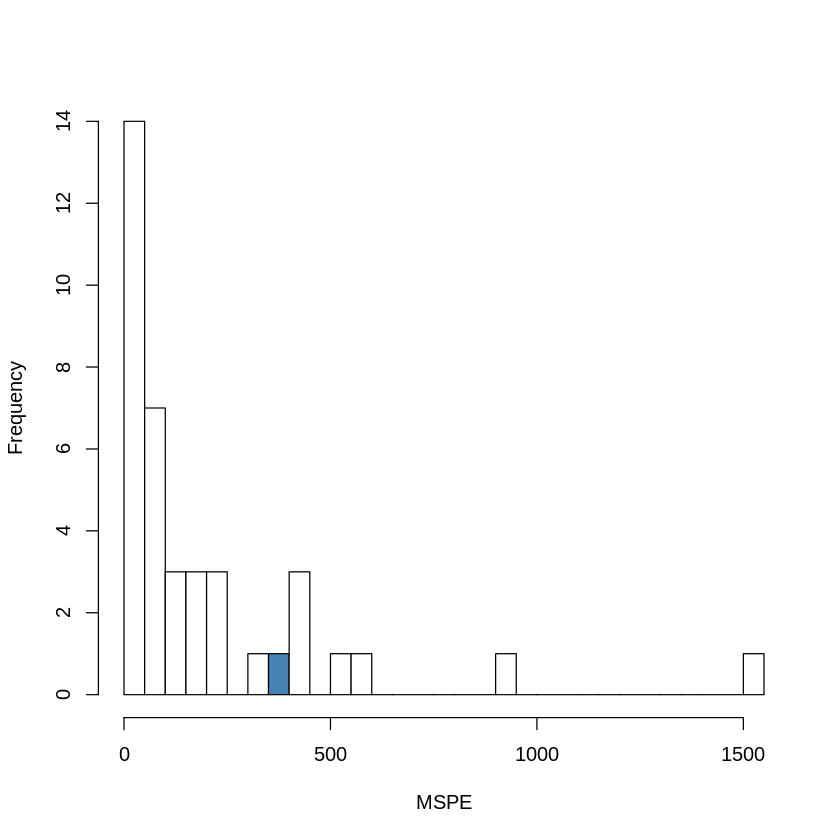

[1] "MSPE, p-value : 0.205"
[1] "MSPE ratio, p-value : 0.026"


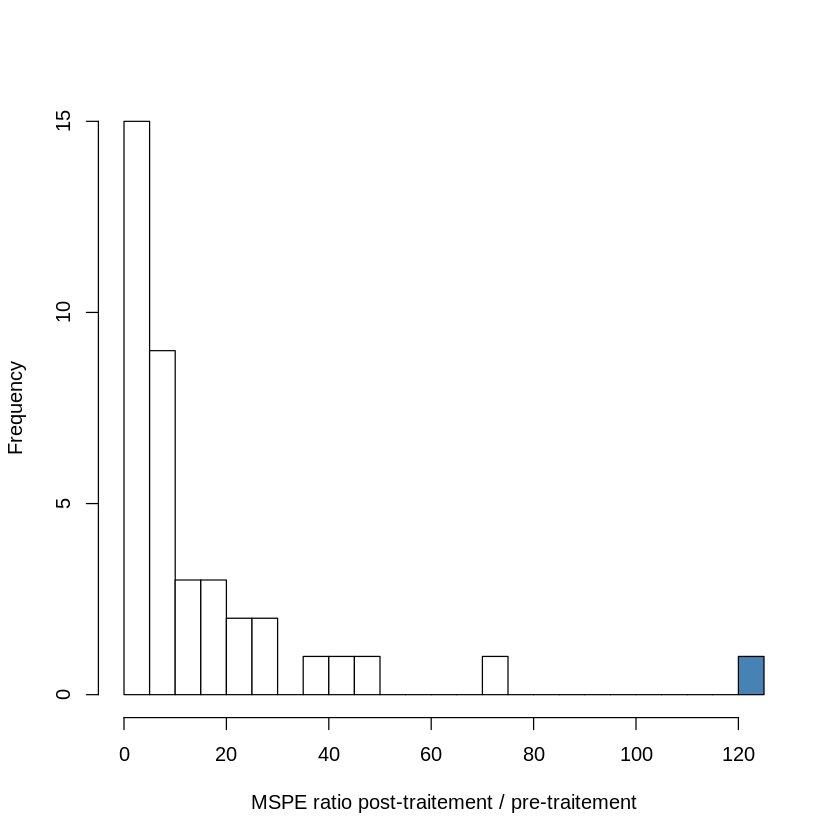

In [ ]:
print(paste(rep("=", 80), collapse=""))
print("STATS : MSPE ET MSPE RATIO")
print(paste(rep("=", 80), collapse=""))

# Calcul des statistiques de test
testStats = data.frame()
preTreatment = mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)
postTreatment = mapply(function(x) paste("SmokingCons", x, sep=""), 1989:2000)
                       
for(i in data[, 'State_ID']){ 
    TE = data[data[, 'State_ID']==i, smokeNames] - contrefactuels[i,]
    testStats[i, "MSPE"] = apply(TE[postTreatment]^2, 1, mean)
    testStats[i, "MSPE_ratio"] = apply(TE[postTreatment]^2, 1, mean) / apply(TE[preTreatment]^2, 1, mean)
}

rownames(testStats) = rownames(data[order(data[,"State_ID"]),])

hist(testStats[,'MSPE'],
     breaks=38,
     main="",
    xlab="MSPE",
    col=c(rep("white", 7), "steelblue", rep("white", 20)))

hist(testStats[,'MSPE_ratio'],
     breaks=38,
    main="",
    xlab="MSPE ratio post-traitement / pre-traitement",
    col=c(rep("white", 24), "steelblue"))


print(paste("MSPE, p-value :", round(mean(testStats[,'MSPE'] >= testStats[3,'MSPE']),3)))
print(paste("MSPE ratio, p-value :", round(mean(testStats[,'MSPE_ratio'] >= testStats[3,'MSPE_ratio']), 3)))

In [ ]:
jpeg("Tobacco_Fig_4.jpg",res=150, width = 1500, height = 750)
par(mfrow=c(1,2))
hist(testStats[,'MSPE'],
     breaks=38,
     main="",
    xlab="MSPE",
    col=c(rep("white", 7), "steelblue", rep("white", 20)))

hist(testStats[,'MSPE_ratio'],
     breaks=38,
    main="",
    xlab="MSPE ratio post-traitement / pre-traitement",
    col=c(rep("white", 24), "steelblue"))
dev.off()



png 
  2

# 5. INFERENCE -- INTERVALLE DE CONFIANCE -- Figure 10.6

In [ ]:
compute.pval <- function(data, outcome, Wsol, C){
    #' fonction pour calculer la p-value à chaque date
    #' Utilise l'ATE comme statistique
    #' @param data: the dataframe
    #' @param outcome: tobacco consumption for that year, SmokingConsXXXX
    #' @param Wsol: the weights
    #' @param C: the constant of the null hypothesis
    
    theta.reshuffled = vector(length=nrow(data))
    
    for(i in data[, "State_ID"]){
        newOutcome = data[, outcome] + as.numeric(i!=3)*C*(data[, "State_ID"]==i)  - as.numeric(i!=3)*C*(data[, "State_ID"]==3)
        theta.reshuffled[i] = newOutcome[data[, "State_ID"]==i] - newOutcome[data[, "State_ID"]!=i]%*%weights[i,]
    }
    theta.obs = theta.reshuffled[3] # California id = 3
    p.val = mean(abs(theta.reshuffled - C) >= abs(theta.obs-C))
    return(list(p.val=p.val,
                theta.reshuffled=theta.reshuffled))
}

compute.pval.MSPE.ratio <- function(data, outcomes, postTreatment, Wsol, C){
    #' fonction pour calculer la p-value à partir du MSPE ratio
    #' @param data: the dataframe
    #' @param outcomes: consommation de tabac
    #' @param postTreatment: indicatrice de la periode post-traitement
    #' @param Wsol: the weights
    #' @param C: the constant of the null hypothesis
    
    ratio.reshuffled = vector(length=nrow(data))
    
    for(i in data[, "State_ID"]){
        TE = vector(length=length(outcomes))
        for(t in 1:length(outcomes)){
            if(outcomes[t] %in% postTreatment){
                newOutcome = data[, outcomes[t]] + as.numeric(i!=3)*C*(data[, "State_ID"]==i)  - as.numeric(i!=3)*C*(data[, "State_ID"]==3)
                TE[t] = newOutcome[data[, "State_ID"]==i] - newOutcome[data[, "State_ID"]!=i]%*%weights[i,] - C
            } else {
                newOutcome = data[, outcomes[t]]
                TE[t] = newOutcome[data[, "State_ID"]==i] - newOutcome[data[, "State_ID"]!=i]%*%weights[i,]
            }
            
        }
        ratio.reshuffled[i] = mean(TE[outcomes %in% postTreatment]^2) / mean(TE[!(outcomes %in% postTreatment)]^2)
    }
    ratio.obs = ratio.reshuffled[3] # California id = 3
    p.val = mean(ratio.reshuffled >= ratio.obs)
    return(list(p.val=p.val,
                ratio.reshuffled=ratio.reshuffled))
}

In [ ]:
alpha = .2

# 1. Upper bound
res0 = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=theta.obs)
b = 0; eps = .01
repeat{
    res0 = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=b)
    if(res0$p.val < alpha) break
    res1 = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=b+eps)
    b = b + (alpha - res0$p.val)*eps/(res1$p.val-res0$p.val)
}
a = mean(treatmentPlot)-10
f_a = 1-alpha
repeat{
    m = (a+b)/2
    res = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=m)
    f_m = res$p.val - alpha
    if(f_m*f_a > 0){
        a = m
        f_a = f_m
    } else {
        b = m
    }
    if(abs(b-a) < .001) break
    }
Cu = (a+b)/2

# 2. Lower bound
res0 = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=theta.obs)
a = -50
repeat{
    res0 = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=a)
    if(res0$p.val < alpha) break
    res1 = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=a-eps)
    a = a + (alpha - res0$p.val)*eps/(res0$p.val-res1$p.val)
}
b = -20
f_b = 1-alpha
repeat{
    m = (a+b)/2
    res = compute.pval.MSPE.ratio(data, outcomes=smokeNames, postTreatment=postTreatment, Wsol=weights, C=m)
    f_m = res$p.val - alpha
    if(f_m*f_b > 0){
        b = m
        f_b = f_m
    } else {
        a = m
    }
    if(abs(b-a) < .001) break
    }
Cl = (a+b)/2

print(paste0(alpha," confidence interval : [",round(Cl,2),",",round(Cu, 2),"]")) 

# Collecte des données pour le graphe
confidenceInterval_global = matrix(rep(treatmentEffect_hat, 2), ncol=2)
rownames(confidenceInterval_global) = smokeNames
confidenceInterval_global[c('SmokingCons1988', postTreatment),1] = Cl
confidenceInterval_global[c('SmokingCons1988', postTreatment),2] = Cu
confidenceInterval_global[!(smokeNames %in% c('SmokingCons1988', postTreatment)),] = NA 

[1] "================================================================================"
[1] "CALCUL DE L'INTERVALLE DE CONFIANCE A PARTIR D'UNE HYPOTHESE GLOBALE, PAR DICHOTOMIE"
[1] "================================================================================"
[1] "0.2 confidence interval : [-25.28,-12.14]"


In [ ]:
alpha = .2
confidenceInterval = matrix(nrow=length(smokeNames), ncol=2)
rownames(confidenceInterval) = smokeNames

for(t in 1988:2000){
    outcome = paste0('SmokingCons', t)
    theta.obs = data[data[, 'State_ID']==3, outcome] - contrefactuels[3, smokeNames==outcome]
    
    # 1. Upper bound
    # A. On cherche une valeur initiale
    res0 = compute.pval(data, outcome, weights, C=theta.obs)
    b = max(res0$theta.reshuffled); eps = .01
    repeat{
        res0 = compute.pval(data, outcome, weights, C=b)
        if(res0$p.val < alpha) break
        res1 = compute.pval(data, outcome, weights, C=b+eps)
        b = b + (alpha - res0$p.val)*eps/(res1$p.val-res0$p.val)
    }
    # B. Dichotomie
    a = theta.obs
    f_a = 1-alpha
    repeat{
        m = (a+b)/2
        res = compute.pval(data, outcome, weights, C=m)
        f_m = res$p.val - alpha
        if(f_m*f_a > 0){
            a = m
            f_a = f_m
        } else {
            b = m
        }
        if(abs(b-a) < .001) break
        }
    Cu = (a+b)/2
    
    # 2. Lower bound
    # A. On cherche une valeur initiale
    res0 = compute.pval(data, outcome, weights, C=theta.obs)
    a = min(res0$theta.reshuffled)
    repeat{
        res0 = compute.pval(data, outcome, weights, C=a)
        if(res0$p.val < alpha) break
        res1 = compute.pval(data, outcome, weights, C=a-eps)
        a = a + (alpha - res0$p.val)*eps/(res0$p.val-res1$p.val)
    }
    # B. Dichotomie
    b = theta.obs
    f_b = 1-alpha
    repeat{
        m = (a+b)/2
        res = compute.pval(data, outcome, weights, C=m)
        f_m = res$p.val - alpha
        if(f_m*f_b > 0){
            b = m
            f_b = f_m
        } else {
            a = m
        }
        if(abs(b-a) < .001) break
        }
    Cl = (a+b)/2
  
    print(paste0(t, " , ", alpha," confidence interval : [",round(Cl,2),",",round(Cu, 2),"]")) 
    confidenceInterval[outcome, ] = c(Cl, Cu)
}

[1] "================================================================================"
[1] "CALCUL DE L'INTERVALLE DE CONFIANCE A CHAQUE POINT DU TEMPS, PAR DICHOTOMIE"
[1] "================================================================================"
[1] "1988 , 0.2 confidence interval : [-10.13,9.11]"
[1] "1989 , 0.2 confidence interval : [-15.2,2.49]"
[1] "1990 , 0.2 confidence interval : [-25.05,6.43]"
[1] "1991 , 0.2 confidence interval : [-28.75,2.11]"
[1] "1992 , 0.2 confidence interval : [-28.54,0.79]"
[1] "1993 , 0.2 confidence interval : [-33.93,-1.26]"
[1] "1994 , 0.2 confidence interval : [-40.35,-3.46]"
[1] "1995 , 0.2 confidence interval : [-41.48,-3.54]"
[1] "1996 , 0.2 confidence interval : [-43.68,-2.18]"
[1] "1997 , 0.2 confidence interval : [-47.84,-1.58]"
[1] "1998 , 0.2 confidence interval : [-44.54,-0.17]"
[1] "1999 , 0.2 confidence interval : [-53.6,1.56]"
[1] "2000 , 0.2 confidence interval : [-46.32,-4.55]"


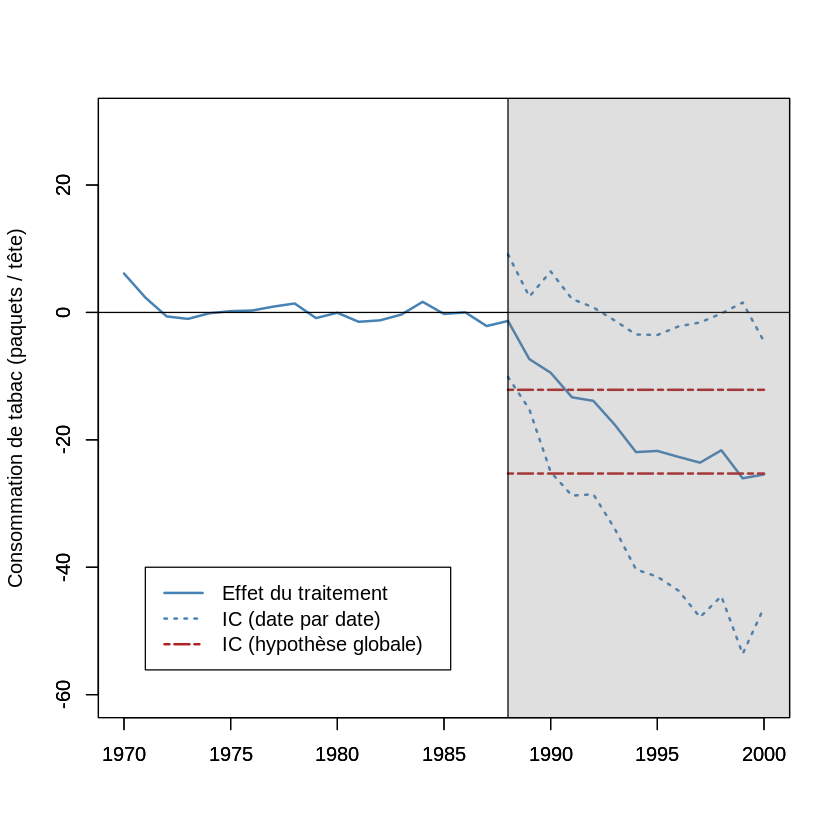

In [ ]:
# FIG 4
treatmentInferencePlot = ts(cbind(c(treatmentEffect_hat),
                                  confidenceInterval[,1],
                                  confidenceInterval[,2],
                                  confidenceInterval_global[,1],
                                  confidenceInterval_global[,2]), start=c(1970), freq=1)

plot(treatmentInferencePlot,
     plot.type="single",
     col=c("steelblue", "steelblue", "steelblue", "firebrick", "firebrick"),
     lwd=2,
     lty= c(1, 3, 3, 6, 6),
     xlab="",
     ylab="Consommation de tabac (paquets / tête)",
     ylim=c(-60, 30))
abline(h=0, lty=c(1))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,-40,
       legend=c("Effet du traitement", "IC (date par date)", "IC (hypothèse globale)"),
       col=c("steelblue", "steelblue", "firebrick"), lwd=2,
       lty=c(1,3,6))

In [ ]:
# SAVE FIG
jpeg("Tobacco_Fig_5.jpg",res=150, width = 1000, height = 1000)
plot(treatmentInferencePlot,
     plot.type="single",
     col=c("steelblue", "steelblue", "steelblue", "firebrick", "firebrick"),
     lwd=2,
     lty= c(1, 3, 3, 6, 6),
     xlab="",
     ylab="Consommation de tabac (paquets / tête)",
     ylim=c(-60, 30))
abline(h=0, lty=c(1))
lim <- par("usr")
rect(1988, lim[3], lim[2], lim[4], col = rgb(0.5,0.5,0.5,1/4))
axis(1) ## add axes back
axis(2)
box() 
legend(1971,-40,
       legend=c("Effet du traitement", "IC (date par date)", "IC (hypothèse globale)"),
       col=c("steelblue", "steelblue", "firebrick"), lwd=2,
       lty=c(1,3,6))
dev.off()

png 
  2

# Test via la procédure de Chernozhukov et al. (2017)

In [ ]:
print(paste(rep("=", 80), collapse=""))
print("CALCUL DES POIDS POUR TEST CHERNOZHUKOV ET AL. (2017)")
print(paste(rep("=", 80), collapse=""))

# On teste l'hypothèse nulle d'absence d'effet de traitement

X1 = t(data[data[,"Treated"]==1, c("Income", "RetailPrice", "Young", "BeerCons", "Smoking1988","Smoking1980","Smoking1975", smokeNames)])
X0 = t(data[data[,"Treated"]==0, c("Income", "RetailPrice", "Young", "BeerCons", "Smoking1988","Smoking1980","Smoking1975", smokeNames)])

Z1 = t(data[data[,"Treated"]==1, mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)])
Z0 = t(data[data[,"Treated"]==0, mapply(function(x) paste("SmokingCons", x, sep=""), 1970:1988)])

solution = synth(X1=X1,
                 X0=X0,
                 Z0=Z0,
                 Z1=Z1,
                 custom.v = NULL,
                 optimxmethod = "Nelder-Mead",
                 verbose=TRUE)   
                                        
W_conformal = solution$solution.w                             

[1] "================================================================================"
[1] "CALCUL DES POIDS POUR TEST CHERNOZHUKOV ET AL. (2017)"
[1] "================================================================================"
X1,X0,Z1,Z0 were individually input (not dataprep object.)


**************** 
 searching for synthetic control unit  
 
                     p1         p2         p3         p4         p5         p6
Nelder-Mead 0.005209653 0.02925563 0.02615175 0.02604428 0.02743305 0.03536143
                    p7         p8         p9       p10        p11       p12
Nelder-Mead 0.03243455 0.03300012 0.02887675 0.0277792 0.02945365 0.0294165
                   p13        p14        p15       p16       p17        p18
Nelder-Mead 0.02746699 0.03369089 0.02868105 0.0196227 0.0276939 0.02739081
                   p19        p20        p21        p22        p23        p24
Nelder-Mead 0.02809157 0.02777931 0.02736381 0.02623198 0.02738114 0.02658518
                   p25     

In [ ]:
print(paste(rep("=", 80), collapse=""))
print("CALCUL DE LA STATISTIQUE DE TEST")
print(paste(rep("=", 80), collapse=""))

n_perm = 10000

post_treat = smokeNames %in% mapply(function(x) paste("SmokingCons", x, sep=""), 1989:2000)
u_hat = data[data[,"Treated"]==1, smokeNames] - t(as.matrix(data[data[,"Treated"]==0, smokeNames]))%*%W_conformal

stat_obs = sum(abs(u_hat[post.ind])) # Statistique observée

u_hat_p = matrix(unlist(replicate(n_perm, sample(u_hat, replace=F))), ncol=n_perm)
stats_permut = apply(abs(u_hat_p[post_treat,]), 2, sum) # Statistiques permutation
                                    
conformal_pval = (1+sum(stats_permut>=stat_obs))/(n_perm+1)
print(paste0("p-value avec l'inférence conformelle : ", round(conformal_pval, 3)))

[1] "================================================================================"
[1] "CALCUL DE LA STATISTIQUE DE TEST"
[1] "================================================================================"
[1] "p-value avec l'inférence conformelle : 0"
